Check also https://www.authorea.com/users/173169/articles/208172-october-25-2017-summary-of-individual-fish-stochastic-swimming-model-and-fitting-results

Check coordinate system.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from numba import jit

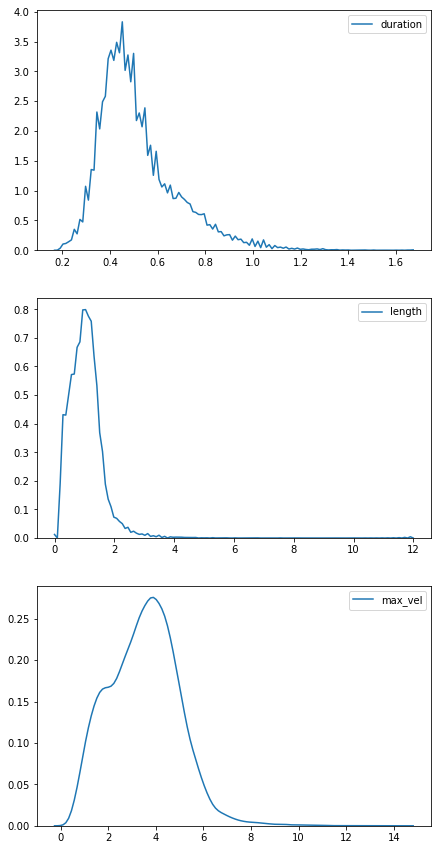

In [2]:
df = pd.read_csv("../../data/processed/kicks26.01.2017.csv")
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'], bw=.002, ax=ax[0])
sns.kdeplot(df['length'],bw=.002, ax=ax[1])
sns.kdeplot(df['max_vel'], ax=ax[2])

In [3]:
#df = df.drop(df[df['neighbor_distance'] < 10].index) # No kicks where fish are close
#df = df.drop(df[df['geometric_leader'] != 'f0'].index) 
df = df.drop(df[df['fish_id'] != 'f0'].index)

df.index = np.arange(0, len(df))
#df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,length,max_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,rel_orientation,wall_distance_f0,wall_angle_f0,wall_distance_f1,wall_angle_f1
count,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000
mean,-0.069474,0.532373,0.890722,2.988633,8.898151,0.237307,-0.093872,-0.061268,0.213674,4.553304,0.792627,3.350984,1.029979
std,0.681823,0.172393,0.581987,1.466586,6.799954,1.768195,2.209741,1.267802,1.509781,2.770197,1.404779,2.773301,1.217258
min,-3.107903,0.172446,0.000616,0.339036,0.307148,-3.139345,-3.141592,-3.099970,-3.141026,0.012418,-3.141333,0.013712,-3.141384
25%,-0.464515,0.411954,0.477648,1.781051,2.931437,-1.146016,-2.228963,-1.018523,-0.644658,2.501090,0.178487,0.921320,0.747817
50%,-0.055168,0.498177,0.817659,2.850255,6.586980,0.353300,-0.761856,-0.104026,0.255697,4.203591,1.272346,2.701492,1.393316
75%,0.290473,0.613141,1.206400,4.010272,14.208209,1.755099,2.147372,0.877161,1.278242,6.210158,1.702106,5.098390,1.707931
max,3.134379,1.666976,6.057586,11.949437,27.416808,3.141006,3.141264,3.094474,3.140423,13.857656,3.140474,13.592190,3.140939


In [4]:
# Select only entries where the kicking fish is the focal one
heading_change = df['heading_change'].values
wall_distance0 = df['wall_distance_f0'].values
wall_angle0 = -df['wall_angle_f0'].values
wall_distance1 = df['wall_distance_f1'].values
wall_angle1 = -df['wall_angle_f1'].values
leader = df['geometric_leader'].values
fish_id = df['fish_id'].values

# Discretize into I x J boxes
I = 40 # 40
J = 30 # 30
WALL_RADIUS = 14
boxlim_f = np.linspace(0, WALL_RADIUS, I + 1)
boxlim_O = np.linspace(-np.pi, np.pi, J + 1)

f = np.zeros(I )# 0... radius=14
O = np.zeros(J) # -pi ... pi

In [5]:
boxcount = np.zeros((I,J)) + 1 # dirty hack
boxheading = np.zeros((I,J))
for i in range(0, len(wall_distance0)):
    wall_distance = None
    wall_angle = None
    #if leader[i] != fish_id[i]:
    #    continue
    if fish_id[i] == 'f0':
        wall_distance = wall_distance0[i]
        wall_angle = wall_angle0[i]
    else:
        wall_distance = wall_distance1[i]
        wall_angle = wall_angle1[i]
        
    box_f = np.digitize(wall_distance, boxlim_f, right=False) - 1
    box_O = np.digitize(wall_angle, boxlim_O, right=False) - 1
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += heading_change[i]
    
    # Add inverse angle as well
    box_f = np.digitize(wall_distance, boxlim_f, right=False) - 1
    box_O = np.digitize(-wall_angle, boxlim_O, right=False) - 1
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += -heading_change[i]
    
# No entry in box -> average heading is zero!
with np.errstate(divide='ignore'):
    boxheading = np.divide(boxheading, boxcount)
boxheading[np.isnan(boxheading)] = 0

In [6]:
# Fitting
def step(f, O):

    oldF = np.copy(f)
    damping = 0.25
    for i in range(0, I):
        newF = np.sum(boxcount[i] * boxheading[i] * O) / np.sum(boxcount[i] * O**2)
        #if np.isnan(newF):
        #    newF = f[i]
        #print(newF)
        f[i] = (1 - damping) * f[i] + damping * newF
    
    for j in range(0, J):
        newO = np.sum(boxcount[:,j] * boxheading[:,j] * f) / np.sum(boxcount[:,j] * f**2)
        #if np.isnan(newO):
        #    newO = O[j]
        O[j] = (1 - damping) * O[j] + damping * newO
    
    # Normalize J s.t. its average square is one
    norm = (np.sum(O**2)/J)**0.5 #np.linalg.norm(O*2)
    if norm >= 10e-2:
        O = (O / norm)
        f = (f * norm)

    return f, O

In [7]:
j = 8
np.sum(boxcount[:,j] * boxheading[:,j] * f) / np.sum(boxcount[:,j] * f**2), O[j]

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


(nan, 0.0)

In [8]:
convergence = 10e-10

# Init f and O with 'reasonable' values
f = np.exp(-(boxlim_f[:I]/4)**2)
#f = np.zeros(boxlim_f[:I].shape) + 10

O = np.sin(boxlim_O[:J])# odd function + 1

# Optimize
for i in range(0, 1000):
    oldF = np.copy(f)
    oldO = np.copy(O)
    f, O = step(f, O)
    if (np.linalg.norm(oldO - O) <= convergence and np.linalg.norm(oldF - f) <= convergence):
        print(f"Converged after {i} iterations!")
        break
print(i)

Converged after 148 iterations!
148


0.610462480349
Fallof -6.289333885913051, in BL -10.482223143188419
[ 0.88047455  4.76071469  0.45852908]


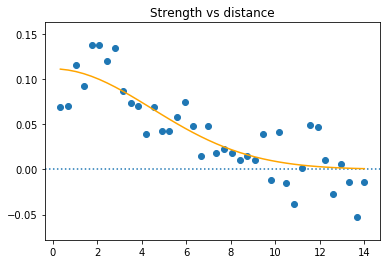

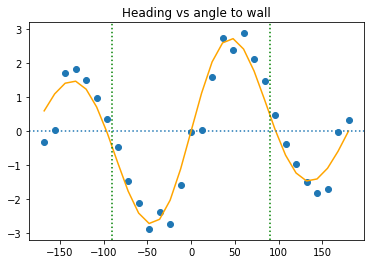

In [9]:
# Estimate similar functional forms to paper
def wall_distance(x, l_d, s_d):
    return s_d * np.exp(-(x/l_d)**2 )

#https://stackoverflow.com/questions/32590720/create-scipy-curve-fitting-definitions-for-fourier-series-dynamically
def angle_fun(x, *a):
    ret = 1
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos(deg * x)
    return a[0] * np.sin(x) * ret

a, _ = curve_fit(angle_fun, boxlim_O[1:], O[:], [1.0] * 5)
print(a[0])
O /= a[0]
f *= a[0]
a, _ = curve_fit(angle_fun, boxlim_O[1:], O[:], [1.0] * 3)

l_d, s_d = curve_fit(wall_distance, boxlim_f[1:], f[0:])[0]

print(f"Fallof {l_d}, in BL {l_d/0.6}")
print(a)

plt.scatter(boxlim_f[1:], f[:])
plt.axhline(0, linestyle='dotted')
plt.plot(boxlim_f[1:], wall_distance(boxlim_f[1:], l_d, s_d), c='orange')
plt.title("Strength vs distance")

plt.figure()
plt.scatter(np.rad2deg(boxlim_O[1:]), O[0:])
plt.plot(np.rad2deg(boxlim_O[1:]), angle_fun(boxlim_O[1:], *a), c='orange')

plt.axhline(0, linestyle='dotted')
plt.axvline(90, linestyle='dotted', c='g')
plt.axvline(-90, linestyle='dotted', c='g')
plt.title("Heading vs angle to wall")

In [10]:
# Try grad.desc as a sanity check
def calc_wall_error(heading_changes, wall_distances, wall_angles, params, fFit, OFit):
    lambda_reg = 0.0
    return np.sum( (heading_changes - fFit(wall_distances) * OFit(wall_angles))**2 )

#fCur = lambda dist: f(dist, 1.9)
#OCur = lambda angle: O(angle, 0.8, 0.0)
#calc_wall_error(heading_change, wall_distance0, wall_angle0, fCur, OCur)

In [11]:
def compute_r2(model, x, y):
    residuals = y - model(x)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)

In [12]:
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.integrate import quad
np.set_printoptions(suppress=True)

# Data
heading_change = df['heading_change'].values
wall_distance0 = df['wall_distance_f0'].values
wall_angle0 = -df['wall_angle_f0'].values
xdata = np.vstack((wall_distance0, wall_angle0))

# Double data by magic
xdata_reflected = np.vstack(( wall_distance0, -wall_angle0))
heading_change_reflected = -heading_change

reflect = False
if reflect:    
    xdata = np.hstack((xdata, xdata_reflected))
    ydata = np.hstack((heading_change, heading_change_reflected))
else:
    ydata = heading_change

# Model
angular_model = 'sin'

angular = {'calovi': lambda angle, p1, p2: np.sin(angle) * (1 + p1 * np.cos(2*angle) + p2*np.cos(4*angle) ),
         'sin': lambda angle, p1, p2, p3: p1 * np.sin(angle) + p2 * np.sin( 2 * angle ) + p3 * np.sin( 3* angle),
         'sin-cos': lambda angle, a1, a2, b1, b2 : (a1 * np.sin(angle) + a2 * np.sin(2*angle)) * \
            (b1 * np.cos(angle) + b2 * np.cos(2*angle) + 1),
         'shifted-sin-cos': lambda angle, a1, a2, b1, b2:
                (a1 * np.cos(angle) + a2 * np.sin(2 * (angle + np.pi/2))) *
                (-b1 * np.sin(angle) + b2 * (2 * np.cos(angle + np.pi/2)) + 1)}
init_x = {'calovi': np.array([6, 1.0, 0.7, 0.0]),
          'sin':  np.array([6, 1.0, 0.7, 0.0, 0.0]),
          'sin-cos': np.array([6, 1.0, 1.0, 1.0, 1.0, 1.0]),
          'shifted-sin-cos': np.array([6, 1.0, 1.0, 1.0, 1.0, 1.0])}


f = lambda dist, *params: params[1] * np.exp(-(dist/params[0])**2 )
O = angular[angular_model]

def model(xdata, *params):
    fCur = lambda dist: f(dist, *params[0:2])
    OCur = lambda angle: O(angle, *params[2:])    
    return fCur(xdata[0]) * OCur(xdata[1])

def residuals(params, head, dist, angle):
    fCur = lambda dist: f(dist, *params[0:2])
    OCur = lambda angle: O(angle, *params[2:])   
    return fCur(dist)*OCur(angle) - heading_change

#https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
def toMin(params):
    fCur = lambda dist: f(dist, *params[0:2])
    OCur = lambda angle: O(angle, *params[2:])
    return calc_wall_error(ydata, xdata[0], xdata[1], params, fCur, OCur)

x0 = init_x[angular_model]
l_bounds = np.array([-np.inf] * len(x0))
u_bounds = np.array([ np.inf] * len(x0))
l_bounds[0] = 0.0 # no negative decay
bounds = (l_bounds, u_bounds)

res = curve_fit(model, xdata=xdata, ydata=ydata, p0=x0, bounds=bounds)
x_opt = res[0]

print(f"Curve fit reached error of {toMin(x_opt)} with params={str(x_opt)}")
print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
print(f"Random params reached error of {toMin(x0)} with params={x0}")

# Calculate error for mean heading change as model
mean_heading = np.mean(ydata)
mean_heading_error = calc_wall_error(ydata, None, None, None,\
                                     lambda x: 1, lambda x: mean_heading)
print(1/len(ydata) * np.sum((ydata - mean_heading)**2))
print(f"Predicting the average heading {mean_heading} for each heading leads to an error of {mean_heading_error}")

fitted_model = lambda xdata: model(xdata, *x_opt)
print(f"Model has r^2 of {compute_r2(fitted_model, xdata, ydata)}")
yHat = model(xdata, *x_opt)
print(f"Correlation={np.corrcoef(ydata, yHat)[0,1]}")

Curve fit reached error of 6228.090416640305 with params=[ 6.17257933  0.38673537  0.16127991  0.66624282  0.01448324]
1-Std-error of params is [       0.50929425  1105844.19522526   461169.23859416  1905077.23499276
    41413.85887938]
Random params reached error of 7976.301912349496 with params=[ 6.   1.   0.7  0.   0. ]
0.464848336355
Predicting the average heading -0.06947437836530193 for each heading leads to an error of 6346.109487915655
Model has r^2 of 0.018597074554115967
Correlation=0.15127115481036235


0.386735370865 0.23505023250897034
Multiplier is 0.09090223884132015


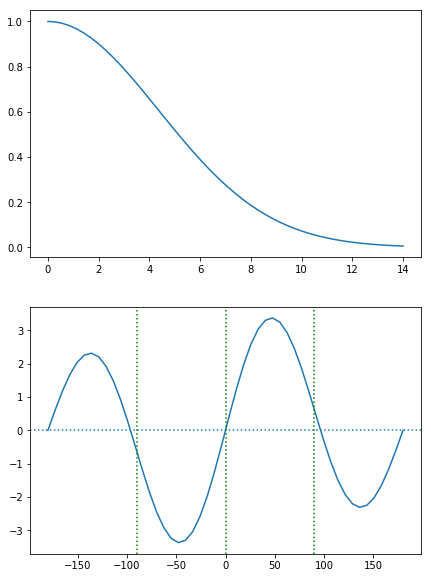

In [13]:
def get_norm_const(OCur, angles):
    return 1/(2*np.pi) * quad(lambda a: OCur(a)**2, -np.pi, np.pi)[0]

def plotFit(params, angles):
    fCur = lambda dist: f(dist, params[0],1.0) # no scaling here
    OCur = lambda angle: O(angle, *params[2:]) 
    norm_const = get_norm_const(OCur, angles)
    print(params[1], norm_const)
    print(f"Multiplier is {norm_const * params[1]}")
    
    fig, ax = plt.subplots(2, 1, figsize=(7,10) )
    
    ax[0].plot(np.linspace(0, 14), fCur(np.linspace(0,14)))
    ax[1].plot(np.rad2deg(np.linspace(-np.pi, np.pi)), OCur(np.linspace(-np.pi, np.pi))/norm_const)
    plt.axhline(0, linestyle='dotted')
    ax[1].axvline(90, linestyle='dotted', c='g')
    ax[1].axvline(0.0, linestyle='dotted', c='g')
    ax[1].axvline(-90, linestyle='dotted', c='g')
plotFit(x_opt, ydata)

[  0.57578791   1.44754253   1.20040668   1.48726749   1.06820192
   1.29922393   1.38351046   1.23543193   1.06077997   0.93653437
   1.03119351   0.7666297    0.84936497   0.58247266   0.77675593
   0.54838498   0.71197067   0.80047423   0.56831847   0.61576973
   0.39708853   0.42889111   0.54363935   0.32803289   0.38629646
   0.53498326   0.37627147   0.38544564   0.31821697   0.09591269
  -0.00844347   0.06172123   0.57745885   0.36453401   0.21183019
   0.63181824  -0.09163345  -2.33235745  -0.7116689  -13.62646658
  -0.40518888  -0.0417303    0.19385198   0.28683771   0.29783958
   0.31571568   0.25316718   0.19181566   0.11242658   0.01190801
  -0.1523056   -0.25373481  -0.38471366  -0.52837521  -0.54449168
  -0.57622849  -0.5300688   -0.56177766  -0.40037816  -0.38208054
  -0.36421863  -0.29694326  -0.23116563  -0.04880066  -0.11107632
  -0.11034388  -0.12581759  -0.07220332  -0.1267626   -0.04489077
  -0.07219879  -0.00738929  -0.13519684  -0.1992539   -0.2531965
   0.100716

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


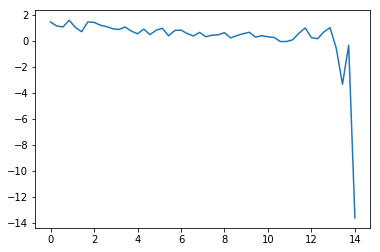

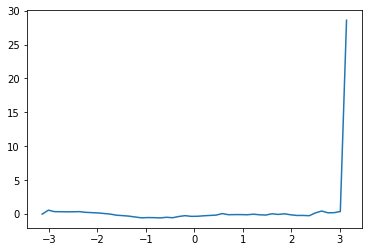

In [14]:
# Try piecewise linear fit
def piecewise_linear(x, bounds, params):
    params = np.array(params)
    
    # params[-1] is a boundary value
    boxes = np.linspace(bounds[0], bounds[1], len(params))
    idx = np.digitize(x, boxes).astype(np.int32) - 1
    #print(idx.shape)

    #return (boxes[idx] - boxes[idx -1])/( params[idx] - params[idx -1] )
    return (params[idx-1] * (boxes[idx] - x) + 
            params[idx] * (x - boxes[idx - 1]))  / (boxes[idx] - boxes[idx-1])

def interp_model(xdata, *params):
    scale = params[0]
    params_exp = params[1:40]
    params_ang = params[40:80]
    
    f = piecewise_linear(xdata[0], (0, 14), params_exp)
    O = piecewise_linear(xdata[1], (-np.pi, np.pi), params_ang)

    return scale * f * O

fInit = np.exp(-(np.linspace(0, 14, 40))/6)
OInit = np.exp(np.sin(np.linspace(-np.pi, np.pi, 40)))
x0 = np.hstack(([1], fInit, OInit))
res = curve_fit(interp_model, xdata=xdata, ydata=ydata, p0=x0)
print(res[0])

fOpt = res[0][1:40]
OOpt = res[0][41:80]

fig, ax = plt.subplots()
ax.plot(np.linspace(0, 14), piecewise_linear(np.linspace(0,14), (0, 14), fOpt))
fig, ax = plt.subplots()
ax.plot(np.linspace(-np.pi, np.pi), piecewise_linear(np.linspace(-np.pi,np.pi), (-np.pi, np.pi), OOpt))


In [15]:
b = np.array([1,2,3,4])
b[np.array([1,2])]

array([2, 3])

In [16]:
heading_change = df['heading_change'].values
wall_distance0 = df['wall_distance_f0'].values
wall_angle0 = df['wall_angle_f0'].values
wall_distance1 = df['wall_distance_f1'].values
wall_angle1 = df['wall_angle_f1'].values
leader = df['geometric_leader'].values
fish_id = df['fish_id'].values

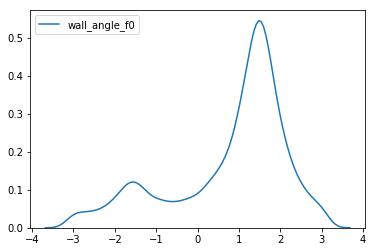

In [17]:
sns.kdeplot(df['wall_angle_f0'])

In [18]:
np.mean(df['heading_change']), np.std(df['heading_change'])

(-0.06947437836530194, 0.6817978706000735)

In [19]:
dft = df [df['wall_distance_f0'] >= 0.95*np.max(df['wall_distance_f0'])]
np.mean(dft['heading_change']), np.std(dft['heading_change'])

(0.015706368370486546, 0.5173493284087338)

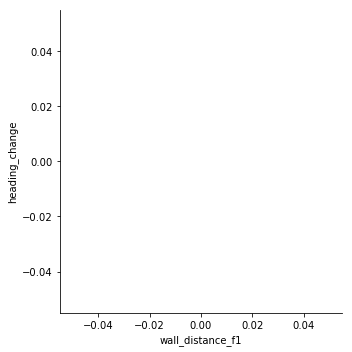

In [21]:
dff = df[ df['fish_id'] == 'f1']
sns.lmplot(data=dff, x='wall_distance_f1', y='heading_change')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

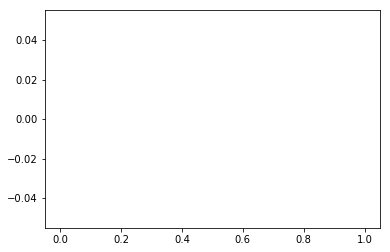

In [22]:
plt.hist(dff['wall_angle_f0'])

(array([  178.,   174.,   235.,   190.,   305.,   523.,  1179.,  2823.,
          935.,   291.]),
 array([-3.14138398, -2.5132397 , -1.88509541, -1.25695113, -0.62880684,
        -0.00066256,  0.62748173,  1.25562601,  1.8837703 ,  2.51191458,
         3.14005887]),
 <a list of 10 Patch objects>)

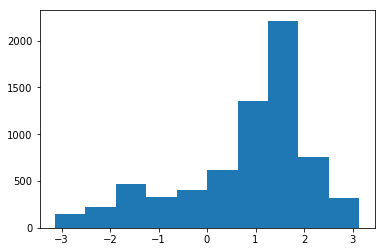

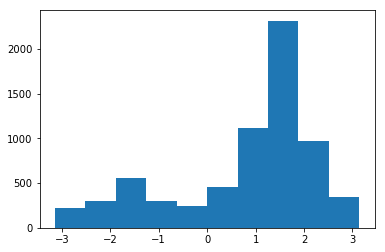

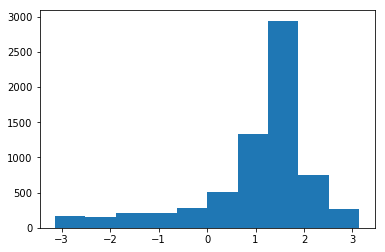

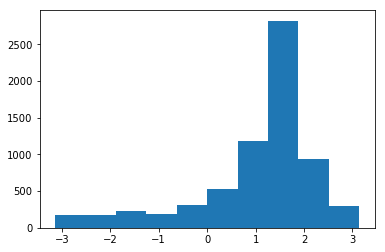

In [23]:
plt.hist(df[ df['geometric_leader'] == 'f0']['wall_angle_f0'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f0']['wall_angle_f0'])

plt.figure()

plt.hist(df[ df['geometric_leader'] == 'f1']['wall_angle_f1'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f1']['wall_angle_f1'])

(array([ 2325.,  1177.,  1030.,   829.,   662.,   398.,   192.,   133.,
           72.,    15.]),
 array([  0.05476692,   1.40198436,   2.7492018 ,   4.09641923,
          5.44363667,   6.79085411,   8.13807155,   9.48528898,
         10.83250642,  12.17972386,  13.5269413 ]),
 <a list of 10 Patch objects>)

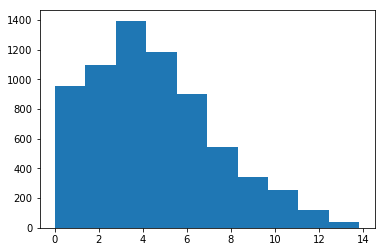

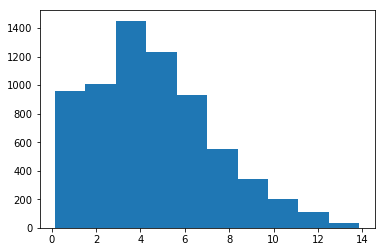

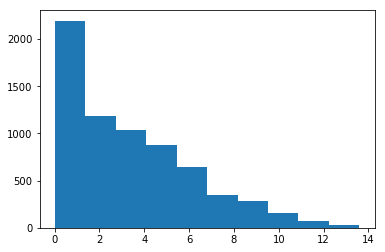

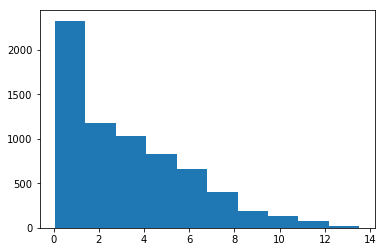

In [24]:
plt.hist(df[ df['geometric_leader'] == 'f0']['wall_distance_f0'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f0']['wall_distance_f0'])

plt.figure()

plt.hist(df[ df['geometric_leader'] == 'f1']['wall_distance_f1'])
plt.figure()
plt.hist(df[ df['geometric_leader'] != 'f1']['wall_distance_f1'])

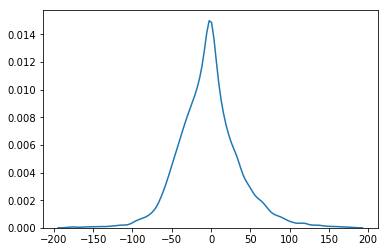

In [25]:
dff = df[ df['fish_id'] == 'f0' ]
sns.kdeplot(np.rad2deg(dff['heading_change'] * np.sign(dff['wall_angle_f0'])))